In [ ]:
import torch
from rindti.data import DTIDataset
from rindti.models import ClassificationModel, RegressionModel
import yaml
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from sklearn.metrics import mean_squared_error
from torch_geometric.data import Data, Batch
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolAlign
from functools import reduce
import pandas as pd
import os
import pickle
import ast
from tqdm import tqdm
from rdkit.Chem.rdmolfiles import MolFromMol2File
from rdkit.Chem import rdMolTransforms  
from scipy.spatial import cKDTree
from matplotlib.ticker import LogLocator, FuncFormatter, PercentFormatter
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')
RDLogger.DisableLog('rdApp.info')


In [2]:
config_path="config\dti\kiba.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
model_config = config["model"]
data_config = config["datamodule"]

In [3]:
test_dataset = DTIDataset(
    filename=data_config["filename"],  
    exp_name=data_config["exp_name"],  
    split="test",                      
)

d:\Pipeline\rindti\rindti\data\datasets.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices, self.config = torch.load(self.processed_paths[self.split

TO GET THE KLIFS KIBA DATAPOINTS

In [ ]:
klifs_kiba=pd.read_csv("KLIFS_KIBA/KLIFSKIBA.csv")

In [5]:
klifs_kiba

,Unnamed: 0,accession,Protein_ID,kinase_ID,Drug_ID,ligand_ID,standard_type,standard_value,standard_units,structure_ID,Value
0,0,O00141,O00141,64.0,CHEMBL549906,1003,IC50,63.0,nM,3270.0,2.371912
1,1,O00141,O00141,64.0,CHEMBL550795,1004,IC50,40.0,nM,3271.0,2.358002
2,3,O00311,O00311,267.0,CHEMBL2030402,1507,IC50,3.4,nM,4823.0,2.071882
3,4,O00311,O00311,267.0,CHEMBL225519,1508,IC50,10.0,nM,4827.0,0.658522
4,20,O14757,O14757,121.0,CHEMBL1170126,460,IC50,6500.0,nM,1668.0,3.812913
...,...,...,...,...,...,...,...,...,...,...,...
886,2226,Q9UQM7,Q9UQM7,113.0,CHEMBL288441,252,Kd,4500.0,nM,2473.0,3.653213
887,2227,Q9Y2K2,Q9Y2K2,134.0,CHEMBL288441,252,Kd,160.0,nM,15241.0,1.806180
888,2232,Q9Y6E0,Q9Y6E0,380.0,CHEMBL191003,1685,Kd,180.0,nM,5606.0,2.255273
889,2233,Q9Y6E0,Q9Y6E0,380.0,CHEMBL288441,252,IC50,3.9,nM,5587.0,0.585309


In [6]:
kiba_final=pd.read_csv("datasets/kiba_new/resources/tables/lig.tsv",sep="\t")

GET SMILES AND CORRESPONDING DATAPOINTS WITH STRUCTURE_ID IN A SINGLE DATAFRAME


In [7]:
merged_df = klifs_kiba.merge(kiba_final, on='Drug_ID', how='left')

In [8]:
merged_df

,Unnamed: 0,accession,Protein_ID,kinase_ID,Drug_ID,ligand_ID,standard_type,standard_value,standard_units,structure_ID,Value,Drug
0,0,O00141,O00141,64.0,CHEMBL549906,1003,IC50,63.0,nM,3270.0,2.371912,O=C(O)Cc1ccc(-c2c[nH]c3ncc(-c4ccc5ccccc5c4)cc2...
1,1,O00141,O00141,64.0,CHEMBL550795,1004,IC50,40.0,nM,3271.0,2.358002,O=C(O)c1ccc(-c2c[nH]c3ncc(-c4ccccc4)cc23)cc1
2,3,O00311,O00311,267.0,CHEMBL2030402,1507,IC50,3.4,nM,4823.0,2.071882,O=c1[nH]c([C@@H]2CCCN2)nc2c1oc1ccc(Cl)cc12
3,4,O00311,O00311,267.0,CHEMBL225519,1508,IC50,10.0,nM,4827.0,0.658522,O=C1NCCc2[nH]c(-c3ccncc3)cc21
4,20,O14757,O14757,121.0,CHEMBL1170126,460,IC50,6500.0,nM,1668.0,3.812913,c1ccc2c(-c3cnc4cnc(-c5cn[nH]c5)cn34)c[nH]c2c1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,2226,Q9UQM7,Q9UQM7,113.0,CHEMBL288441,252,Kd,4500.0,nM,2473.0,3.653213,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...
887,2227,Q9Y2K2,Q9Y2K2,134.0,CHEMBL288441,252,Kd,160.0,nM,15241.0,1.806180,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...
888,2232,Q9Y6E0,Q9Y6E0,380.0,CHEMBL191003,1685,Kd,180.0,nM,5606.0,2.255273,Nc1nc(Nc2ccc(S(N)(=O)=O)cc2)nn1C(=O)c1c(F)cccc1F
889,2233,Q9Y6E0,Q9Y6E0,380.0,CHEMBL288441,252,IC50,3.9,nM,5587.0,0.585309,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...


TO FIND THE INDEX TO MATCH THE ATTRIBUTION PICKLE FILE

In [ ]:


matched_rows = []

for i in tqdm(range(len(test_dataset))):
    item = test_dataset[i]

    prot_id = item["prot_id"]
    drug_id = item["drug_id"]

    match = merged_df[
        (merged_df["Protein_ID"] == prot_id) &
        (merged_df["Drug_ID"] == drug_id)
    ]

    if not match.empty:
        match = match.copy()
        match["index"] = i
        matched_rows.append(match)

merged_with_index = pd.concat(matched_rows, ignore_index=True)


100%|██████████| 33236/33236 [00:13<00:00, 2459.60it/s]


In [10]:
merged_with_index

,Unnamed: 0,accession,Protein_ID,kinase_ID,Drug_ID,ligand_ID,standard_type,standard_value,standard_units,structure_ID,Value,Drug,index
0,1606,Q05397,Q05397,425.0,CHEMBL205098,86,IC50,200.00,nM,225.0,2.313683,COc1cc(Nc2ncc3ccn(-c4ccccn4)c3n2)cc(OC)c1OC,0
1,1579,Q02763,Q02763,477.0,CHEMBL245549,1766,IC50,17.00,nM,5555.0,1.230449,Cc1ccc(NC(=O)c2cccc(C(F)(F)F)c2)cc1Nc1ncccc1-c...,1
2,1952,Q16539,Q16539,249.0,CHEMBL328242,832,IC50,0.60,nM,5061.0,-0.221849,CC(C)N1CCC(c2cc(-c3ccc(F)cc3Cl)c3c(c2)N(c2c(Cl...,2
3,1419,P51955,P51955,286.0,CHEMBL1236145,101,IC50,1600.00,nM,298.0,3.204120,COc1cc(-c2cnc(N)c(-c3ccc(C(=O)O)cc3)n2)cc(OC)c1OC,3
4,543,P08581,P08581,446.0,CHEMBL1766528,877,IC50,0.93,nM,2953.0,-0.031517,CN1CCN(c2cnc3cc(C(F)(F)F)cc(NCc4cccc([N+](=O)[...,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,546,P08581,P08581,446.0,CHEMBL2029678,912,IC50,1.00,nM,3016.0,0.150515,COCCOc1cnc2ccc([C@H](C)n3nnc4ccn(-c5cc(C)ns5)c...,32847
801,1882,Q16539,Q16539,249.0,CHEMBL1171204,1658,IC50,251.19,nM,5224.0,2.600002,Cc1ccccc1C(=O)c1c[nH]c(C(=O)NCc2ccco2)c1,32910
802,1614,Q05397,Q05397,425.0,CHEMBL514554,3937,IC50,100.00,nM,13316.0,1.588046,CS(=O)(=O)c1cccc(CNc2nc(Nc3ccc4c(c3)CCC(=O)N4)...,32955
803,283,O60674,O60674,439.0,CHEMBL495727,1772,IC50,1.00,nM,8047.0,0.039591,O=C(Nc1c[nH]nc1-c1nc2ccc(CN3CCOCC3)cc2[nH]1)NC...,33092


TO FIND THE OVERLAP OF ATTRIBUTION METHODS

In [ ]:


EXPLANATION_METHODS = ["integrated", "shap", "inputxgrad", "guided"]
ATTRIBUTION_ROOT   = "attributions/kiba"
TOP_PERCENT        = 0.5   # Top 50% of atoms

def get_top_percent_indices(scores, percent=0.5):
    k = max(1, int(len(scores) * percent))
   
    print(f"  → scores length = {len(scores)}, k = {k}")
    return set(np.argsort(scores)[-k:])

method_scores = {}
for method in EXPLANATION_METHODS:
    p = os.path.join(ATTRIBUTION_ROOT, f"{method}.pkl")
    if not os.path.exists(p):
        raise FileNotFoundError(f"Missing attribution file for {method}: {p}")
    with open(p, "rb") as f:
        raw_list = pickle.load(f)

 
    lookup = { entry["index"]: entry["attributions"] 
               for entry in raw_list }
    method_scores[method] = lookup

 
    sample_idx = next(iter(lookup))
    print(f"{method!r}: loaded {len(lookup)} entries, sample index {sample_idx}, array shape {lookup[sample_idx].shape}")


overlap_summary = []
for _, row in merged_with_index.iterrows():
    idx = row["index"]


    if any(idx not in method_scores[m] for m in EXPLANATION_METHODS):
        continue


    top_sets = []
    print(f"\nIndex {idx}:")  
    for m in EXPLANATION_METHODS:
        scores = method_scores[m][idx]
        top = get_top_percent_indices(scores, TOP_PERCENT)
        print(f"  {m:16s} → top indices = {sorted(top)}")
        top_sets.append(top)
    overlap = set.intersection(*top_sets)
    print(f"  → OVERLAP = {sorted(overlap)} (size {len(overlap)})") 

    overlap_summary.append({
        "index":             idx,
        "Protein_ID":        row["Protein_ID"],
        "structure_ID":      row["structure_ID"],
        "ligand_ID":         row["ligand_ID"],
        "Drug_ID":           row["Drug_ID"],
        "Smiles":            row["Drug"],
        "num_overlap":       len(overlap),
        "overlapping_nodes": sorted(overlap),
    })

# 3) Build the DataFrame
overlap_df = pd.DataFrame(overlap_summary)
print(f"\nFinal overlap_df has {len(overlap_df)} rows")


'integrated': loaded 33236 entries, sample index 0, array shape (28,)
'shap': loaded 33236 entries, sample index 0, array shape (28,)
'inputxgrad': loaded 33236 entries, sample index 0, array shape (28,)
'guided': loaded 33236 entries, sample index 0, array shape (28,)

Index 0:
  → scores length = 28, k = 14
  integrated       → top indices = [3, 4, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 18, 21]
  → scores length = 28, k = 14
  shap             → top indices = [3, 4, 7, 8, 10, 11, 13, 14, 15, 17, 18, 20, 21, 26]
  → scores length = 28, k = 14
  inputxgrad       → top indices = [3, 4, 5, 7, 8, 10, 11, 13, 14, 17, 18, 20, 21, 26]
  → scores length = 28, k = 14
  guided           → top indices = [2, 4, 7, 8, 9, 10, 11, 13, 16, 21, 22, 23, 24, 27]
  → OVERLAP = [4, 7, 8, 10, 11, 13, 21] (size 7)

Index 1:
  → scores length = 33, k = 16
  integrated       → top indices = [0, 5, 7, 10, 13, 14, 15, 16, 20, 22, 23, 24, 26, 29, 30, 32]
  → scores length = 33, k = 16
  shap             → top indi

In [12]:
overlap_df

,index,Protein_ID,structure_ID,ligand_ID,Drug_ID,Smiles,num_overlap,overlapping_nodes
0,0,Q05397,225.0,86,CHEMBL205098,COc1cc(Nc2ncc3ccn(-c4ccccn4)c3n2)cc(OC)c1OC,7,"[4, 7, 8, 10, 11, 13, 21]"
1,1,Q02763,5555.0,1766,CHEMBL245549,Cc1ccc(NC(=O)c2cccc(C(F)(F)F)c2)cc1Nc1ncccc1-c...,5,"[0, 5, 13, 26, 29]"
2,2,Q16539,5061.0,832,CHEMBL328242,CC(C)N1CCC(c2cc(-c3ccc(F)cc3Cl)c3c(c2)N(c2c(Cl...,8,"[10, 16, 19, 20, 22, 23, 28, 30]"
3,3,P51955,298.0,101,CHEMBL1236145,COc1cc(-c2cnc(N)c(-c3ccc(C(=O)O)cc3)n2)cc(OC)c1OC,5,"[2, 5, 15, 23, 24]"
4,4,P08581,2953.0,877,CHEMBL1766528,CN1CCN(c2cnc3cc(C(F)(F)F)cc(NCc4cccc([N+](=O)[...,4,"[4, 12, 14, 24]"
...,...,...,...,...,...,...,...,...
800,32847,P08581,3016.0,912,CHEMBL2029678,COCCOc1cnc2ccc([C@H](C)n3nnc4ccn(-c5cc(C)ns5)c...,4,"[1, 4, 16, 29]"
801,32910,Q16539,5224.0,1658,CHEMBL1171204,Cc1ccccc1C(=O)c1c[nH]c(C(=O)NCc2ccco2)c1,4,"[7, 9, 12, 17]"
802,32955,Q05397,13316.0,3937,CHEMBL514554,CS(=O)(=O)c1cccc(CNc2nc(Nc3ccc4c(c3)CCC(=O)N4)...,3,"[10, 17, 24]"
803,33092,O60674,8047.0,1772,CHEMBL495727,O=C(Nc1c[nH]nc1-c1nc2ccc(CN3CCOCC3)cc2[nH]1)NC...,7,"[1, 5, 11, 13, 17, 21, 23]"


checking proximity of the overlapping atoms


Updated with proportion compared to total number of atoms

In [ ]:

LIGAND_ROOT = "kiba_klifsanalysis/klifs_ligands"
POCKET_ROOT = "kiba_klifsanalysis/klifs_pocketstructures"
THRESHOLDS  = [2.0, 3.0, 4.0]



def mol2_heavy_atom_ids_in_file_order(mol2_path: str):
    atom_ids = []
    in_atom = False
    with open(mol2_path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith("@<TRIPOS>ATOM"):
                in_atom = True
                continue
            if line.startswith("@<TRIPOS>") and in_atom:
                break
            if in_atom:
                parts = line.split()
                if len(parts) < 6:
                    continue
                atom_id = int(parts[0])
                atom_name = parts[1]
                atom_type = parts[5]
                is_h = atom_name.upper().startswith("H") or atom_type.upper().startswith("H")
                if not is_h:
                    atom_ids.append(atom_id)
    return atom_ids


def extract_and_map_ligand_heavy_only(ligand_path, smiles, imp_tpl_idxs):

    lig3d = MolFromMol2File(ligand_path, removeHs=False)
    if lig3d is None:
        return None, None, None, None, "cannot parse ligand MOL2"
    lig_heavy = Chem.RemoveHs(lig3d)

    heavy_atom_ids_file_order = mol2_heavy_atom_ids_in_file_order(ligand_path)
    

    tpl = Chem.MolFromSmiles(smiles)
    if tpl is None:
        return None, None, None, None, "cannot parse SMILES"
    tpl = Chem.RemoveHs(tpl)
    ranks = list(Chem.CanonicalRankAtoms(tpl, breakTies=True))
    tpl = Chem.RenumberAtoms(tpl, ranks)
    tpl_symbols = [atom.GetSymbol() for atom in tpl.GetAtoms()]

    try:
        mapped = AllChem.AssignBondOrdersFromTemplate(tpl, lig_heavy)
        if mapped.GetNumHeavyAtoms() != tpl.GetNumHeavyAtoms():
            raise ValueError("atom count mismatch")
        match = mapped.GetSubstructMatch(tpl)
        if not match or len(match) != tpl.GetNumAtoms():
            raise ValueError("cannot match template onto mapped ligand")

      
        mapped_symbols = [atom.GetSymbol() for atom in mapped.GetAtoms()]
        symbol_map = [
            (tpl_idx, tpl_symbols[tpl_idx], mol2_idx, mapped_symbols[mol2_idx])
            for tpl_idx, mol2_idx in enumerate(match)
        ]
        imp_mol2_heavy_idxs = [int(match[int(i)]) for i in imp_tpl_idxs]
        imp_mol2_atom_ids = []
        for iheavy in imp_mol2_heavy_idxs:
            if 0 <= iheavy < len(heavy_atom_ids_file_order):
                imp_mol2_atom_ids.append(int(heavy_atom_ids_file_order[iheavy]))
            else:
                imp_mol2_atom_ids.append(None)  

        mapped_canon = Chem.RenumberAtoms(mapped, match)
        return mapped_canon, symbol_map, imp_mol2_heavy_idxs, imp_mol2_atom_ids, None

    except Exception as e:
        match = lig_heavy.GetSubstructMatch(tpl)
        if not match or len(match) != tpl.GetNumHeavyAtoms():
            return None, None, None, None, f"substructure fallback failed: {e}"

        lig_symbols = [atom.GetSymbol() for atom in lig_heavy.GetAtoms()]
        symbol_map = [
            (tpl_idx, tpl_symbols[tpl_idx], mol2_idx, lig_symbols[mol2_idx])
            for tpl_idx, mol2_idx in enumerate(match)
        ]

        imp_mol2_heavy_idxs = [int(match[int(i)]) for i in imp_tpl_idxs]
        imp_mol2_atom_ids = []
        for iheavy in imp_mol2_heavy_idxs:
            if 0 <= iheavy < len(heavy_atom_ids_file_order):
                imp_mol2_atom_ids.append(int(heavy_atom_ids_file_order[iheavy]))
            else:
                imp_mol2_atom_ids.append(None)

        ligand = Chem.Mol(tpl)
        conf_new = Chem.Conformer(ligand.GetNumAtoms())
        conf_old = lig_heavy.GetConformer()
        for i in range(ligand.GetNumAtoms()):
            pos = conf_old.GetAtomPosition(match[i])
            conf_new.SetAtomPosition(i, pos)
        ligand.AddConformer(conf_new, assignId=True)
        return ligand, symbol_map, imp_mol2_heavy_idxs, imp_mol2_atom_ids, None

def get_coords(mol):
    conf = mol.GetConformer()
    return np.array([list(conf.GetAtomPosition(i)) for i in range(mol.GetNumAtoms())])

def compute_proximity_stats(ligand, pocket, important_idxs):
    coords_all = get_coords(ligand)
    coords_poc = get_coords(pocket)
    tree = cKDTree(coords_poc)
    d_all, idx_all = tree.query(coords_all)
    d_imp = d_all[important_idxs]
    idx_imp = idx_all[important_idxs]

    stats = {}
    for t in THRESHOLDS:
        imp_within = (d_imp <= t).sum()
        total_imp = len(d_imp)
        stats[f"within_{t}A"] = imp_within / total_imp if total_imp else 0.0
        all_within = (d_all <= t).sum()
        stats[f"prop_imp_within_{t}A"] = imp_within / all_within if all_within else 0.0

    stats["min_distances_imp"] = d_imp.tolist()
    stats["min_distances_all"] = d_all.tolist()
    stats["nearest_pocket_idx_imp"] = idx_imp.tolist()
    stats["num_imp"] = len(d_imp)
    stats["num_all"] = len(d_all)
    return stats

def run_proximity(overlap_df):
    printed_once = False
    rows = []

    for _, row in tqdm(overlap_df.iterrows(), total=len(overlap_df)):
        sid = int(row.get("structure_ID", -1))
        smi = row.get("Smiles", "")
        nodes_raw = row.get("overlapping_nodes")
        protein_id=row.get("Protein_ID")
        drug_id=row.get("Drug_ID")
        if not nodes_raw:
            continue

      
        nodes = [int(i) for i in nodes_raw]

        ligand_path = os.path.join(LIGAND_ROOT, f"ligand_{sid}.mol2")
        pocket_path = os.path.join(POCKET_ROOT, f"structure_{sid}.mol2")
        if not os.path.exists(ligand_path) or not os.path.exists(pocket_path):
            continue

        ligand, symbol_map, imp_mol2_heavy_idxs, imp_mol2_atom_ids, err = extract_and_map_ligand_heavy_only(
            ligand_path, smi, nodes_raw
        )
        if err:
            continue


        if not printed_once:
            print(f"Symbol mapping for structure {sid}:")
            for tpl_idx, tpl_sym, mol2_idx, mol2_sym in symbol_map:
                print(f"  SMILES atom {tpl_idx} ({tpl_sym}) → MOL2 heavy-idx {mol2_idx} ({mol2_sym})")
            print(f"Important MOL2 atom_ids (for PyMOL 'id'): {imp_mol2_atom_ids}")
            printed_once = True

        pocket = MolFromMol2File(pocket_path, removeHs=False)
        if pocket is None:
            continue

 
        stats = compute_proximity_stats(ligand, pocket, nodes)

        out = {
            "index": row.get("index"),
            "overlapping_nodes": row.get("overlapping_nodes"),
            "structure_ID": sid,
            "protein_id": protein_id,
            "Drug_ID":  drug_id,
            "mol2_atom_ids": imp_mol2_atom_ids,       
            "smiles": row.get("Smiles"),
            "num_imp": stats["num_imp"],
            "num_all": stats["num_all"],
            "imp_atom_elements": [ligand.GetAtomWithIdx(i).GetSymbol() for i in nodes],
            "imp_atom_distances": [d for d in stats["min_distances_imp"]],
        }
      
        for k, v in stats.items():
            if k.startswith("within_") or k.startswith("prop_imp_"):
                out[k] = v

        rows.append(out)

    return pd.DataFrame(rows)

if __name__ == "__main__":
    overlap_df["overlapping_nodes"] = overlap_df["overlapping_nodes"].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )
    proximity_df = run_proximity(overlap_df)
    proximity_df.to_csv("proximity_threshold_results.csv", index=False)


  0%|          | 1/805 [00:00<01:54,  7.01it/s]

Symbol mapping for structure 225:
  SMILES atom 0 (C) → MOL2 heavy-idx 0 (C)
  SMILES atom 1 (C) → MOL2 heavy-idx 25 (C)
  SMILES atom 2 (C) → MOL2 heavy-idx 7 (C)
  SMILES atom 3 (N) → MOL2 heavy-idx 16 (N)
  SMILES atom 4 (C) → MOL2 heavy-idx 15 (C)
  SMILES atom 5 (C) → MOL2 heavy-idx 24 (C)
  SMILES atom 6 (C) → MOL2 heavy-idx 10 (C)
  SMILES atom 7 (C) → MOL2 heavy-idx 22 (C)
  SMILES atom 8 (C) → MOL2 heavy-idx 19 (C)
  SMILES atom 9 (C) → MOL2 heavy-idx 4 (C)
  SMILES atom 10 (C) → MOL2 heavy-idx 18 (C)
  SMILES atom 11 (C) → MOL2 heavy-idx 20 (C)
  SMILES atom 12 (C) → MOL2 heavy-idx 6 (C)
  SMILES atom 13 (N) → MOL2 heavy-idx 14 (N)
  SMILES atom 14 (C) → MOL2 heavy-idx 13 (C)
  SMILES atom 15 (C) → MOL2 heavy-idx 11 (C)
  SMILES atom 16 (C) → MOL2 heavy-idx 3 (C)
  SMILES atom 17 (N) → MOL2 heavy-idx 12 (N)
  SMILES atom 18 (N) → MOL2 heavy-idx 21 (N)
  SMILES atom 19 (O) → MOL2 heavy-idx 5 (O)
  SMILES atom 20 (C) → MOL2 heavy-idx 23 (C)
  SMILES atom 21 (C) → MOL2 heavy-idx

  0%|          | 3/805 [00:00<01:15, 10.67it/s][14:12:00] WARNING: More than one matching pattern found - picking one

  5%|▌         | 43/805 [00:03<01:00, 12.68it/s][14:12:03] WARNING: More than one matching pattern found - picking one

  7%|▋         | 58/805 [00:04<01:00, 12.30it/s][14:12:05] WARNING: More than one matching pattern found - picking one

 12%|█▏        | 93/805 [00:07<00:54, 12.95it/s][14:12:07] WARNING: More than one matching pattern found - picking one

 14%|█▎        | 109/805 [00:08<00:51, 13.55it/s][14:12:08] WARNING: More than one matching pattern found - picking one

 15%|█▍        | 117/805 [00:09<00:55, 12.42it/s][14:12:09] WARNING: More than one matching pattern found - picking one

 17%|█▋        | 133/805 [00:10<00:55, 12.00it/s][14:12:10] WARNING: More than one matching pattern found - picking one

 21%|██        | 166/805 [00:13<00:55, 11.47it/s][14:12:13] WARNING: More than one matching pattern found - picking one

 25%|██▍       | 200/805 [00:15<00:41

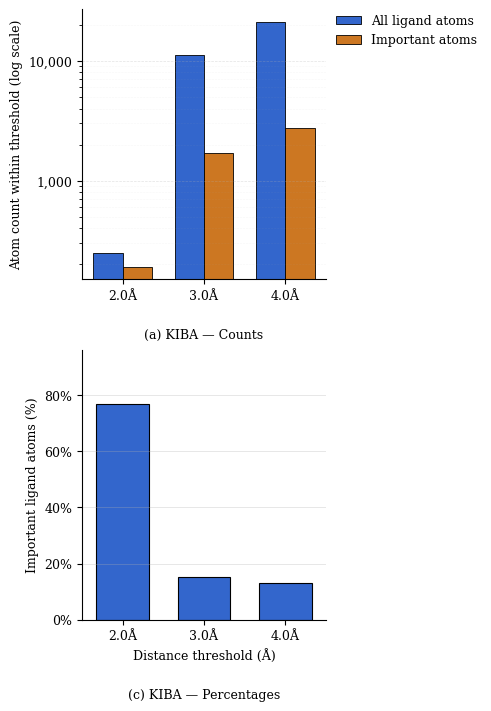

In [ ]:
thresholds = [2.0, 3.0, 4.0]
c_all, c_imp = "#3366CC", "#CC7722"
bar_width = 0.36

total_all, total_imp = [], []
for t in thresholds:
    within_col = f"within_{t}A"
    prop_col   = f"prop_imp_within_{t}A"

    imp_per_complex = proximity_df[within_col] * proximity_df["num_imp"]
    total_imp.append(int(round(imp_per_complex.sum())))

    all_per_complex = pd.Series(0.0, index=proximity_df.index)
    mask = proximity_df[prop_col] > 0
    all_per_complex.loc[mask] = imp_per_complex.loc[mask] / proximity_df.loc[mask, prop_col]
    total_all.append(int(round(all_per_complex.sum())))

percentages = [(imp/tot * 100.0) if tot > 0 else 0.0
               for imp, tot in zip(total_imp, total_all)]

x = np.arange(len(thresholds))
xticklabels = [f"{t:.1f}Å" for t in thresholds]

plt.rcParams.update({
    "font.size": 9,
    "font.family": "serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 0.8,
})

fig = plt.figure(figsize=(4.8, 7.0), constrained_layout=True)
gs  = fig.add_gridspec(nrows=4, ncols=1,
                       height_ratios=[1.0, 0.11, 1.0, 0.11])  
fig.set_constrained_layout_pads(hspace=0.05, wspace=0.02)

ax_top = fig.add_subplot(gs[0, 0])
ax_cap_top = fig.add_subplot(gs[1, 0]); ax_cap_top.axis("off")
ax_bot = fig.add_subplot(gs[2, 0], sharex=ax_top)
ax_cap_bot = fig.add_subplot(gs[3, 0]); ax_cap_bot.axis("off")
ax_top.bar(x - bar_width/2, total_all, width=bar_width, label="All ligand atoms",
           color=c_all, edgecolor="black", linewidth=0.6)
ax_top.bar(x + bar_width/2, total_imp, width=bar_width, label="Important atoms",
           color=c_imp, edgecolor="black", linewidth=0.6)

ax_top.set_yscale("log")
ax_top.yaxis.set_major_locator(LogLocator(base=10, numticks=6))
ax_top.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2,10)*0.1, numticks=12))
ax_top.yaxis.set_major_formatter(FuncFormatter(lambda v, p: f"{int(v):,}" if v >= 1 else f"{v:g}"))
ax_top.set_ylabel("Atom count within threshold (log scale)")
ax_top.grid(True, axis="y", which="major", linestyle="--", linewidth=0.5, alpha=0.35)
ax_top.grid(True, axis="y", which="minor", linestyle=":", linewidth=0.4, alpha=0.2)
ax_top.legend(frameon=False, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)

ax_cap_top.text(0.5, 0.2, "(a) KIBA — Counts",
                ha="center", va="center", fontsize=9)

ax_bot.bar(x, percentages, width=0.65, color=c_all,
           edgecolor="black", linewidth=0.8)
ax_bot.set_ylabel("Important ligand atoms (%)")
ax_bot.yaxis.set_major_formatter(PercentFormatter(100))
ax_bot.set_ylim(0, min(100, max(percentages)*1.25 if percentages else 100))
ax_bot.grid(axis="y", linewidth=0.6, alpha=0.35)
ax_bot.set_xticks(x)
ax_bot.set_xticklabels(xticklabels)
ax_bot.set_xlabel("Distance threshold (Å)")

ax_cap_bot.text(0.5, 0.2, "(c) KIBA — Percentages",
                ha="center", va="center", fontsize=9)
fig.savefig("kiba_counts_plus_percentages_labeled.pdf")
fig.savefig("kiba_counts_plus_percentages_labeled.png", dpi=600)
plt.show()
